## Kaggle competition  Santander customer transaction using Neural Network in PyTorch

It's a fairly simple neural network with enhancements targeted for later. 
Steps:
1. Load data
2. Add features
3. Model training using 5-fold StratifiedKfol

In [47]:
import torch
import numpy as np
from torch import nn, optim
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F
import torchvision

from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_recall_curve, average_precision_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import os
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


### Check for GPU

In [2]:
cuda = torch.cuda.is_available()
if cuda:
    device = "cuda"
    print("cuda available")
torch.cuda.get_device_name(0)    

cuda available


'Tesla P100-PCIE-16GB'

### Load data and scale between (-1,1) using standard scaler

In [9]:
os.listdir('../input')

['train.csv', 'sample_submission.csv', 'test.csv']

In [41]:
%%time
df_train_raw = pd.read_csv('../input/train.csv')
df_test_raw = pd.read_csv('../input/test.csv')

CPU times: user 12.9 s, sys: 596 ms, total: 13.5 s
Wall time: 13.5 s


In [67]:
%%time
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

CPU times: user 196 ms, sys: 504 ms, total: 700 ms
Wall time: 786 ms


In [68]:
train_cols = [col for col in df_train.columns if col not in ['ID_code', 'target']]
y_train = df_train['target']

In [69]:
df_train.shape

(200000, 202)

In [70]:
ss = StandardScaler()
rs = RobustScaler() 
df_train[train_cols] = ss.fit_transform(df_train[train_cols])
df_test[train_cols] = ss.fit_transform(df_test[train_cols])

In [71]:
interactions= {'var_81':['var_53','var_139','var_12','var_76'],
               'var_12':['var_139','var_26','var_22', 'var_53','var_110','var_13'],
               'var_139':['var_146','var_26','var_53', 'var_6', 'var_118'],
               'var_53':['var_110','var_6'],
              'var_26':['var_110','var_109','var_12'],
              'var_118':['var_156'],
              'var_9':['var_89'],
              'var_22':['var_28','var_99','var_26'],
              'var_166':['var_110'],
              'var_146':['var_40','var_0'],
              'var_80':['var_12']}

In [72]:
%%time
for col in train_cols:
        df_train[col+'_2'] = df_train[col] * df_train[col]
        df_train[col+'_3'] = df_train[col] * df_train[col]* df_train[col]
#         df_train[col+'_4'] = df_train[col] * df_train[col]* df_train[col]* df_train[col]
        df_test[col+'_2'] = df_test[col] * df_test[col]
        df_test[col+'_3'] = df_test[col] * df_test[col]* df_test[col]

CPU times: user 3.21 s, sys: 5.15 s, total: 8.36 s
Wall time: 8.08 s


In [73]:
%%time
for df in [df_train, df_test]:
    df['sum'] = df[train_cols].sum(axis=1)  
    df['min'] = df[train_cols].min(axis=1)
    df['max'] = df[train_cols].max(axis=1)
    df['mean'] = df[train_cols].mean(axis=1)
    df['std'] = df[train_cols].std(axis=1)
    df['skew'] = df[train_cols].skew(axis=1)
    df['kurt'] = df[train_cols].kurtosis(axis=1)
    df['med'] = df[train_cols].median(axis=1)

CPU times: user 11.8 s, sys: 19.4 s, total: 31.2 s
Wall time: 31.2 s


In [74]:
%%time
for key in interactions:
    for value in interactions[key]:
        df_train[key+'_'+value+'_mul'] = df_train[key]*df_train[value]
        df_train[key+'_'+value+'_div'] = df_train[key]/df_train[value]
        df_train[key+'_'+value+'_sum'] = df_train[key] + df_train[value]
        df_train[key+'_'+value+'_sub'] = df_train[key] - df_train[value]
        
        df_test[key+'_'+value+'_mul'] = df_test[key]*df_test[value]
        df_test[key+'_'+value+'_div'] = df_test[key]/df_test[value]
        df_test[key+'_'+value+'_sum'] = df_test[key] + df_test[value]
        df_test[key+'_'+value+'_sub'] = df_test[key] - df_test[value]

CPU times: user 1.05 s, sys: 2.06 s, total: 3.11 s
Wall time: 3.05 s


In [75]:
df_train_raw.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [80]:
df_train['num_zero_rows'] = (df_train_raw[train_cols] == 0).astype(int).sum(axis=1)
df_test['num_zero_rows'] = (df_test_raw[train_cols] == 0).astype(int).sum(axis=1)

In [81]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_0_2,var_0_3,var_1_2,var_1_3,var_2_2,var_2_3,var_3_2,var_3_3,var_4_2,var_4_3,var_5_2,var_5_3,var_6_2,var_6_3,var_7_2,var_7_3,var_8_2,var_8_3,var_9_2,var_9_3,var_10_2,var_10_3,var_11_2,var_11_3,var_12_2,var_12_3,var_13_2,var_13_3,var_14_2,var_14_3,var_15_2,var_15_3,var_16_2,var_16_3,var_17_2,var_17_3,var_18_2,var_18_3,var_19_2,var_19_3,var_20_2,var_20_3,var_21_2,var_21_3,var_22_2,var_22_3,var_23_2,var_23_3,var_24_2,var_24_3,var_25_2,var_25_3,var_26_2,var_26_3,var_27_2,var_27_3,var_28_2,var_28_3,var_29_2,var_29_3,var_30_2,var_30_3,var_31_2,var_31_3,var_32_2,var_32_3,var_33_2,var_33_3,var_34_2,var_34_3,var_35_2,var_35_3,var_36_2,var_36_3,var_37_2,var_37_3,var_38_2,var_38_3,var_39_2,var_39_3,var_40_2,var_40_3,var_41_2,var_41_3,var_42_2,var_42_3,var_43_2,var_43_3,var_44_2,var_44_3,var_45_2,var_45_3,var_46_2,var_46_3,var_47_2,var_47_3,var_48_2,var_48_3,var_49_2,var_49_3,var_50_2,var_50_3,var_51_2,var_51_3,var_52_2,var_52_3,var_53_2,var_53_3,var_54_2,var_54_3,var_55_2,var_55_3,var_56_2,var_56_3,var_57_2,var_57_3,var_58_2,var_58_3,var_59_2,var_59_3,var_60_2,var_60_3,var_61_2,var_61_3,var_62_2,var_62_3,var_63_2,var_63_3,var_64_2,var_64_3,var_65_2,var_65_3,var_66_2,var_66_3,var_67_2,var_67_3,var_68_2,var_68_3,var_69_2,var_69_3,var_70_2,var_70_3,var_71_2,var_71_3,var_72_2,var_72_3,var_73_2,var_73_3,var_74_2,var_74_3,var_75_2,var_75_3,var_76_2,var_76_3,var_77_2,var_77_3,var_78_2,var_78_3,var_79_2,var_79_3,var_80_2,var_80_3,var_81_2,var_81_3,var_82_2,var_82_3,var_83_2,var_83_3,var_84_2,var_84_3,var_85_2,var_85_3,var_86_2,var_86_3,var_87_2,var_87_3,var_88_2,var_88_3,var_89_2,var_89_3,var_90_2,var_90_3,var_91_2,var_91_3,var_92_2,var_92_3,var_93_2,var_93_3,var_94_2,var_94_3,var_95_2,var_95_3,var_96_2,var_96_3,var_97_2,var_97_3,var_98_2,var_98_3,var_99_2,var_99_3,var_100_2,var_100_3,var_101_2,var_101_3,var_102_2,var_102_3,var_103_2,var_103_3,var_104_2,var_104_3,var_105_2,var_105_3,var_106_2,var_106_3,var_107_2,var_107_3,var_108_2,var_108_3,var_109_2,var_109_3,var_110_2,var_110_3,var_111_2,var_111_3,var_112_2,var_112_3,var_113_2,var_113_3,var_114_2,var_114_3,var_115_2,var_115_3,var_116_2,var_116_3,var_117_2,var_117_3,var_118_2,var_118_3,var_119_2,var_119_3,var_120_2,var_120_3,var_121_2,var_121_3,var_122_2,var_122_3,var_123_2,var_123_3,var_124_2,var_124_3,var_125_2,var_125_3,var_126_2,var_126_3,var_127_2,var_127_3,var_128_2,var_128_3,var_129_2,var_129_3,var_130_2,var_130_3,var_131_2,var_131_3,var_132_2,var_132_3,var_133_2,var_133_3,var_134_2,var_134_3,var_135_2,var_

In [82]:
all_train_columns = [col for col in df_train.columns if col not in ['ID_code', 'target']]

### Define a neural network

In [85]:
class classifier(nn.Module):
    
    def __init__(self,input_dim, hidden_dim, dropout = 0.4):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p = dropout)
    
    
    def forward(self,x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x   

In [87]:
model = classifier(len(all_train_columns),200)
print(model)
del model

classifier(
  (fc1): Linear(in_features=725, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.4)
)


### Defining the Stratified K fold

In [90]:
folds = StratifiedKFold(n_splits = 5, shuffle = True)

In [91]:
#Definining the sigmoid function to calculate final results
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [92]:
%%time
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

# Defining the parameters
batch_size = 1000
n_epochs = 10

#Loader for test dataset
test_x = torch.from_numpy(df_test[all_train_columns].values).float()#.cuda()
test_dataset = torch.utils.data.TensorDataset(test_x)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

#Starting the tranining on each fold
for n_fold, (train_idx, val_idx) in enumerate(folds.split(df_train, y_train)):
    running_train_loss, running_val_loss = [],[]
    val_loss_min = np.Inf
#     print(i, train_idx.shape, val_idx.shape)

    print("Fold number: ", n_fold+1)
    
    #Defining the train loader iterator
    train_x_fold = torch.from_numpy(df_train.iloc[train_idx][all_train_columns].values).float().cuda()
    train_y_fold = torch.from_numpy(y_train[train_idx].values).float().cuda()
    train_fold_dataset = torch.utils.data.TensorDataset(train_x_fold,train_y_fold)
    trainloader = torch.utils.data.DataLoader(train_fold_dataset, batch_size = batch_size, shuffle = True)
    
    #Defining the validation dataset loader iterator
    val_x_fold = torch.from_numpy(df_train.iloc[val_idx][all_train_columns].values).float().cuda()
    val_y_fold = torch.from_numpy(y_train[val_idx].values).float().cuda()
    val_fold_dataset = torch.utils.data.TensorDataset(val_x_fold,val_y_fold )
    valloader = torch.utils.data.DataLoader(val_fold_dataset, batch_size = batch_size, shuffle = False)
    
    #Initiating model, optimizer and loss function
    model = classifier(len(all_train_columns),200)
    model.cuda()
    optimizer = optim.Adam(model.parameters(), lr = 0.004)
    # criterion = nn.CrossEntropyLoss() # also number of outputs should be 2
    criterion = nn.BCEWithLogitsLoss()
    
    #Starting the neural network training
    for epoch in range(n_epochs):
        train_loss = 0
        
        for train_x_batch, train_y_batch in trainloader:
            model.train()
            optimizer.zero_grad()
            output = model(train_x_batch)
            loss = criterion(output, train_y_batch.view(-1,1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()/len(trainloader)
        
        #Evaluating on validation dataset
        with torch.no_grad():
            val_loss = 0
            model.eval()
            val_preds = []
            val_true = []
            
            #Stratified Kfold is splitting the dataset a bit weird.. 
            #so have to introduce list methods to store validation and test predictions
            for i, (val_x_batch, val_y_batch) in enumerate(valloader):
                val_output = model(val_x_batch)
                val_loss += (criterion(val_output, val_y_batch.view(-1,1)).item())/len(valloader)
                batch_output = sigmoid(val_output.cpu().numpy().squeeze())
                try:
                    batch_output = list(batch_output)
                except TypeError:
                    batch_output =[batch_output]
                val_preds.extend(batch_output)
                
#                 batch_true = val_y_batch.cpu().numpy().squeeze()
#                 try:
#                     batch_true = list(batch_true)
#                 except TypeError:
#                     batch_true =[batch_true]
#                 val_true.extend(batch_true)
                
        running_train_loss.append(train_loss)
        running_val_loss.append(val_loss)
        
        
        print("Epoch: {}   Training loss: {:.6f}   Validation Loss: {:.6f}    Val_auc:{:.5f}".format(epoch+1,
                                                                              train_loss,
                                                                               val_loss,
                                                                               roc_auc_score(y_train[val_idx].values,
                                                                                             val_preds))
         )
        
        #Saving the model only if validation loss is going down in the epoch
        if val_loss <= val_loss_min:
            print("Validation loss decresed from {:.6f} ----> {:.6f} Saving Model".format(val_loss_min,val_loss))
            torch.save(model.state_dict(), "san_cust_tran_torch.pt")
            val_loss_min = val_loss
            
        
    oof[val_idx] = val_preds    
    print("Fold {} metrics:   Avg Training loss: {:.4f}   Avg Validation Loss: {:.4f}   Val_auc:{:.5f}".format(n_fold+1,
                                                                              np.mean(running_train_loss),
                                                                               np.mean(running_val_loss),
                                                                               roc_auc_score(y_train[val_idx].values,
                                                                                             oof[val_idx])))
    
    #Predicting on test set with the best model in the fold
    y_test_pred_fold = []
    print("Saving test results for best model")
    for (test_x_batch,) in testloader:
        model.load_state_dict(torch.load("san_cust_tran_torch.pt"))
        model.cpu()
        test_output = model(test_x_batch)
        test_batch_output = sigmoid(test_output.detach().numpy().squeeze())
        try:
            test_batch_output = list(test_batch_output)
        except TypeError:
            test_batch_output =[test_batch_output]
        y_test_pred_fold.extend(test_batch_output)
    predictions += np.array(y_test_pred_fold)/folds.n_splits 
    
    print("end of fold: ",n_fold+1,"\n")
        
        

Fold number:  1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 1   Training loss: 0.308262   Validation Loss: 0.246499    Val_auc:0.84767
Validation loss decresed from inf ----> 0.246499 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 2   Training loss: 0.252475   Validation Loss: 0.249001    Val_auc:0.85285


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 3   Training loss: 0.257506   Validation Loss: 0.239803    Val_auc:0.85568
Validation loss decresed from 0.246499 ----> 0.239803 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 4   Training loss: 0.260345   Validation Loss: 0.238422    Val_auc:0.85207
Validation loss decresed from 0.239803 ----> 0.238422 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 5   Training loss: 0.257473   Validation Loss: 0.244494    Val_auc:0.85629
Epoch: 6   Training loss: 0.236386   Validation Loss: 0.236976    Val_auc:0.85586
Validation loss decresed from 0.238422 ----> 0.236976 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 7   Training loss: 0.222767   Validation Loss: 0.236485    Val_auc:0.85743
Validation loss decresed from 0.236976 ----> 0.236485 Saving Model
Epoch: 8   Training loss: 0.217888   Validation Loss: 0.234884    Val_auc:0.85623
Validation loss decresed from 0.236485 ----> 0.234884 Saving Model
Epoch: 9   Training loss: 0.211757   Validation Loss: 0.235642    Val_auc:0.85575
Epoch: 10   Training loss: 0.204928   Validation Loss: 0.239635    Val_auc:0.85093
Fold 1 metrics:   Avg Training loss: 0.2430   Avg Validation Loss: 0.2402   Val_auc:0.85093
Saving test results for best model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


end of fold:  1 

Fold number:  2
Epoch: 1   Training loss: 0.359036   Validation Loss: 0.250687    Val_auc:0.85371
Validation loss decresed from inf ----> 0.250687 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 2   Training loss: 0.257720   Validation Loss: 0.245134    Val_auc:0.85524
Validation loss decresed from 0.250687 ----> 0.245134 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 3   Training loss: 0.258608   Validation Loss: 0.247968    Val_auc:0.85538


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 4   Training loss: 0.243908   Validation Loss: 0.235795    Val_auc:0.86020
Validation loss decresed from 0.245134 ----> 0.235795 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 5   Training loss: 0.234741   Validation Loss: 0.233042    Val_auc:0.85887
Validation loss decresed from 0.235795 ----> 0.233042 Saving Model
Epoch: 6   Training loss: 0.227930   Validation Loss: 0.234007    Val_auc:0.85809


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 7   Training loss: 0.219652   Validation Loss: 0.234429    Val_auc:0.85865
Epoch: 8   Training loss: 0.217459   Validation Loss: 0.233575    Val_auc:0.85699
Epoch: 9   Training loss: 0.209716   Validation Loss: 0.233703    Val_auc:0.85481
Epoch: 10   Training loss: 0.206623   Validation Loss: 0.235948    Val_auc:0.85211
Fold 2 metrics:   Avg Training loss: 0.2435   Avg Validation Loss: 0.2384   Val_auc:0.85211
Saving test results for best model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


end of fold:  2 

Fold number:  3
Epoch: 1   Training loss: 0.295975   Validation Loss: 0.250160    Val_auc:0.84248
Validation loss decresed from inf ----> 0.250160 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 2   Training loss: 0.258686   Validation Loss: 0.258509    Val_auc:0.84837


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 3   Training loss: 0.268806   Validation Loss: 0.241980    Val_auc:0.85104
Validation loss decresed from 0.250160 ----> 0.241980 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 4   Training loss: 0.245208   Validation Loss: 0.241069    Val_auc:0.85084
Validation loss decresed from 0.241980 ----> 0.241069 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 5   Training loss: 0.238265   Validation Loss: 0.239103    Val_auc:0.85302
Validation loss decresed from 0.241069 ----> 0.239103 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 6   Training loss: 0.233472   Validation Loss: 0.242424    Val_auc:0.85067


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 7   Training loss: 0.224110   Validation Loss: 0.252310    Val_auc:0.85106


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 8   Training loss: 0.216257   Validation Loss: 0.241160    Val_auc:0.85128


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 9   Training loss: 0.210961   Validation Loss: 0.246258    Val_auc:0.84692


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 10   Training loss: 0.203909   Validation Loss: 0.249000    Val_auc:0.84517
Fold 3 metrics:   Avg Training loss: 0.2396   Avg Validation Loss: 0.2462   Val_auc:0.84517
Saving test results for best model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


end of fold:  3 

Fold number:  4
Epoch: 1   Training loss: 0.310069   Validation Loss: 0.246088    Val_auc:0.84441
Validation loss decresed from inf ----> 0.246088 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 2   Training loss: 0.259317   Validation Loss: 0.256821    Val_auc:0.84817


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 3   Training loss: 0.265351   Validation Loss: 0.242422    Val_auc:0.85193
Validation loss decresed from 0.246088 ----> 0.242422 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 4   Training loss: 0.268535   Validation Loss: 0.243815    Val_auc:0.85232


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 5   Training loss: 0.246100   Validation Loss: 0.240910    Val_auc:0.85307
Validation loss decresed from 0.242422 ----> 0.240910 Saving Model
Epoch: 6   Training loss: 0.234282   Validation Loss: 0.237468    Val_auc:0.85328
Validation loss decresed from 0.240910 ----> 0.237468 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 7   Training loss: 0.222334   Validation Loss: 0.243955    Val_auc:0.85330
Epoch: 8   Training loss: 0.214824   Validation Loss: 0.239976    Val_auc:0.85212
Epoch: 9   Training loss: 0.208375   Validation Loss: 0.246266    Val_auc:0.85111
Epoch: 10   Training loss: 0.204418   Validation Loss: 0.241191    Val_auc:0.85113
Fold 4 metrics:   Avg Training loss: 0.2434   Avg Validation Loss: 0.2439   Val_auc:0.85113
Saving test results for best model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


end of fold:  4 

Fold number:  5
Epoch: 1   Training loss: 0.302287   Validation Loss: 0.241056    Val_auc:0.85184
Validation loss decresed from inf ----> 0.241056 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 2   Training loss: 0.266510   Validation Loss: 0.249543    Val_auc:0.85493


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 3   Training loss: 0.260266   Validation Loss: 0.236478    Val_auc:0.85843
Validation loss decresed from 0.241056 ----> 0.236478 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 4   Training loss: 0.251665   Validation Loss: 0.247301    Val_auc:0.85856


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 5   Training loss: 0.235301   Validation Loss: 0.234792    Val_auc:0.85998
Validation loss decresed from 0.236478 ----> 0.234792 Saving Model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 6   Training loss: 0.228442   Validation Loss: 0.239479    Val_auc:0.86174
Epoch: 7   Training loss: 0.222440   Validation Loss: 0.240000    Val_auc:0.85895
Epoch: 8   Training loss: 0.221723   Validation Loss: 0.237233    Val_auc:0.85799
Epoch: 9   Training loss: 0.228314   Validation Loss: 0.239984    Val_auc:0.85589


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 10   Training loss: 0.216110   Validation Loss: 0.241270    Val_auc:0.85465
Fold 5 metrics:   Avg Training loss: 0.2433   Avg Validation Loss: 0.2407   Val_auc:0.85465
Saving test results for best model


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


end of fold:  5 

CPU times: user 1min 52s, sys: 13 s, total: 2min 5s
Wall time: 2min 5s


### Checking best iteration

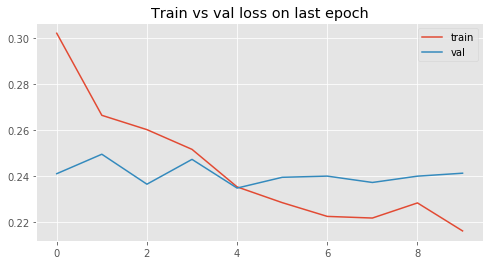

In [93]:
plt.figure(figsize = (8,4))
plt.title("Train vs val loss on last epoch")
plt.plot(running_train_loss, label = "train")
plt.plot(running_val_loss, label = "val")
plt.legend()
plt.show()

### Preparing submission file

In [94]:
sub = pd.DataFrame({'ID_code': df_test.ID_code.values,
                   'target': predictions})
sub.to_csv('sub_pytorch_simplenn.csv', index = False)

1. The first submission gave the LB score of 0.854